# Interstellar Navigation Using New Horizons

*David Munro* and *Tod Lauer*

Analysis for "A Demonstration of Interstellar Navigation Using New Horizons" by Lauer et.al., including figures 3 and 4 and the tables.

## Input data sources

- Gaia DR3 ra, dec, parallax, and proper motion data
   * source_id = 5853498713190525696 for Proxima Cen
   * source_id = 3864972938605115520 for Wolf 359
   * radial velocities from Simbad
- New Horizons observations (Marc Buie)
   * two visits of three images each for Proxima Cen
   * two visits of three images each for Wolf 359
- New Horizons true positions (JPL Horizons)
   * (to check results)
- Earth observations used in section 2 of paper
   * Proxima Cen observed by LCO (Marc Buie Gaia DR3)
   * Wolf 359 observed by Mt. Lemon (Marc Buie Gaia DR3)

In [76]:
# Basic utilities for New Horizons Parallax paper
from datetime import datetime

from numpy import (array, asarray, eye, matmul, pi, cos, sin, sqrt,
                   zeros, empty, newaxis, where, arcsin, arctan2,
                   arccos, arange, cross, interp, sum)
# scipy.linalg generally slightly better than numpy.linalg
from scipy.linalg import svd, inv, solve, pinv
from numpy.ma import MaskedArray

# asfarray deprecated in numpy 2.0
asfarray = lambda x: asarray(x, float)

# Required for gaia_source_id() or get_astrometry() or get_nearest()
# from astroquery.simbad import Simbad
# from astroquery.gaia import Gaia
# -- comment next and uncomment previous two
Simbad = Gaia = None

j2000 = 2451545.0    # Julian date of J2000 epoch
yr = 365.25  # days per Julian year (Gaia unit of time for proper motions)
pc = 3600. * 180./pi  # au/pc = 206264.80625 arcsec/radian
au = 149597870.7  # km/au (exactly)
kms2auyr = 86400*yr / au  # (s/yr) / (km/au) = (au/yr)/(km/s)


# Gaia DR3 source_id:
# 5853498713190525696 for Proxima Cen
# 3864972938605115520 for Wolf 359
def gaia_source_id(name):
    table = Simbad.query_objectids(name)
    names = []
    for row in table:
        name = row['ID']
        if "gaia" in name.lower():
            names.append(name)
    return names


# Gaia gaia_source column names:
# source_id
# ref_epoch (julian years) 2015.5 for DR2, 2016.0 for DR3
# ra (deg) barycentric right ascension in ICRS (or BCRS)
# dec (deg) barycentric declination in ICRS
# parallax (mas)
# pmra (mas/year) proper motion in right ascension direction per Julian year
# pmdec (mas/year) proper motion in declination direction per Julian year
# radial_velocity (km/s)
# ra_error (mas) standard deviation in the ra direction, not in ra angle
# dec_error (mas)
# parallax_error (mas)
# pmra_error (mas/year)
# pmdec_error (mas/year)
# radial_velocity_error (km/s)
# correlation coefficients (covariance = corr*error_i*error_j)
# [ra]  ra_dec_corr  ra_parallax_corr  ra_pmra_corr  ra_pmdec_corr
#       [dec]  dec_parallax_corr  dec_pmra_corr  dec_pmdec_corr
#              [parallax]  parallax_pmra_corr  parallax_pmdec_corr
#                          [pmra]  pmra_pmdec_corr
#                                  [pmdec]
# Note Proxima Cen and Wolf 359 EDR3 are same source_id and values as DR3.
def get_astrometry(*ids, catalog="gaiadr3"):
    cols = ("source_id, ref_epoch, ra, dec, parallax, pmra, pmdec, " +
            "radial_velocity, ra_error, dec_error, parallax_error, " +
            "pmra_error, pmdec_error, radial_velocity_error, " +
            "ra_dec_corr, ra_parallax_corr, ra_pmra_corr, ra_pmdec_corr, " +
            "dec_parallax_corr, dec_pmra_corr, dec_pmdec_corr, " +
            "parallax_pmra_corr, parallax_pmdec_corr, pmra_pmdec_corr")
    query = "SELECT TOP 10 {} FROM {}.gaia_source WHERE source_id = ".format(
        cols, catalog)
    data = []
    for id in ids:
        raw = GaiaCoordinates(Gaia.launch_job(query+str(id)).get_results()[0])
        data.append(raw)
    return data


# http://simbad.cds.unistra.fr/guide/otypes.htx  for otype meanings
def get_nearest(mag=15, parallax=100):
    table = Simbad.query_tap("""
SELECT TOP 100 basic.OID, main_id, RA, DEC, plx_value, V, otype
FROM basic JOIN allfluxes ON oidref = oid
WHERE (plx_value > {}) AND (V <= {})
ORDER BY plx_value DESC;""".format(parallax, mag))
    oid, main_id, ra, dec, plx, vmag, otype = [
        array(table[v]) for v in
        ["oid", "main_id", "ra", "dec", "plx_value", "V", "otype"]]
    main_id = main_id.astype(str)
    otype = otype.astype(str)
    return oid, main_id, ra, dec, plx, vmag, otype


def got_nearest():
    with open("nearby100.txt") as f:
        for line in f:
            if line.startswith("------"):
                break
        rows = []
        for line in f:
            rows.append([col.strip() for col in line.split(",")])
    okay, oid = array([[int(v) for v in row[:2]] for row in rows]).T
    ra, dec, plx, vmag = array([[float(v) for v in r[2:6]] for r in rows]).T
    main_id = array([row[6] for row in rows])
    return okay, oid, ra, dec, plx, vmag, main_id


# Note that LORRI pixels are 4.08 arcsec, tol and tiny are in arcsec.
def mark_multiple(ra, dec, tol=60., tiny=0.1):
    """Mark stars in list which are part of visual multiple star systems."""
    d = to_xyz(ra, dec)
    dd = sqrt(((d[:, newaxis] - d)**2).sum(axis=-1))
    dd += eye(d.shape[0])  # change diagonal elements from zero to one
    dd *= 3600. * 180./pi  # convert radians to arcsec
    multi = where((dd < tol) & (dd > tiny), True, False).any(axis=0)
    maybe = where(dd <= tiny, True, False).any(axis=0) & ~multi
    return multi, maybe


class GaiaCoordinates(object):
    def __init__(self, job_result):
        self.raw = raw = dict(job_result)
        for key in raw:
            if isinstance(raw[key], MaskedArray):
                raw[key] = None  # easier to recognize than MaskedArray
        self.vec0 = array([raw[nm] for nm in
                          ["ra", "dec", "parallax", "pmra", "pmdec"]])
        self.cov0 = self.covariance_matrix(raw)
        self.set_epoch()

    @staticmethod
    def covariance_matrix(record):
        """form 5x5 covariance matrix for (ra, dec, parallax, pmra, pmdec)"""
        names = ["ra", "dec", "parallax", "pmra", "pmdec"]
        std = array([record[nm + "_error"] for nm in names])
        cov = eye(5)
        for i, nmi in enumerate(names):
            for j, nmj in enumerate(names):
                if j == i:
                    continue
                pair = nmi + "_" + nmj if i < j else nmj + "_" + nmi
                cov[i, j] = record[pair + "_corr"]
        return std[:, newaxis] * cov * std

    def djd_from(self, jd_or_jy=None):
        """return input epoch minus ref_epoch in days"""
        if jd_or_jy is None:
            return 0.0

        def jy2jd(jy):
            return 365.25 * (jy - 2000.0) + j2000

        jd0 = jy2jd(self.raw["ref_epoch"])
        jd = jd_or_jy if jd_or_jy > 9999 else jy2jd(jd_or_jy)
        return jd - jd0

    def set_epoch(self, jd_or_jy=None):
        dt = self.djd_from(jd_or_jy) / 365.25  # (year)
        # vec is (ra, dec, parallax, pmra, pmdec)
        vec = self.vec0.copy()  # be sure not to clobber self.vec0
        # Compute tshift matrix, matmul(tshift, vec0) --> vec at jd_or_jy
        tshift = eye(5)
        tshift[0, 3] = dt
        tshift[1, 4] = dt
        # Gaia precision is so high that there can be a significant
        # difference between stepping around the great circle in the
        # (pmra, pmdec) direction and stepping in a rectangular (ra, dec)
        # coordinate system.  Prefer stepping around the great circle.
        vec[:2] = _ra_dec_stepper(vec[0], vec[1], vec[3]*dt, vec[4]*dt)
        deg2mas = 3600000.0
        ra, dec, parallax = vec[:3]
        parallax /= deg2mas
        ra, dec, parallax = [v*pi/180. for v in (ra, dec, parallax)]
        cd, sd = cos(dec), sin(dec)
        ca, sa = cos(ra), sin(ra)
        self.dt = dt
        self.vec = vec
        tshift[0, 3] = dt  # covariances use angle on sky like pmra
        self.cov = cov = matmul(tshift, matmul(self.cov0, tshift.T))
        # Correct parallax for radial velocity if present
        radian = pi/180. / 3600000.  # radians/mas
        if dt and self.raw["radial_velocity"]:
            # 1/parallax in au, since parallax in radians now
            r = 1.0/parallax + self.raw["radial_velocity"] * dt  # in au
            parallax = 1. / r
            varpllx = ((self.raw["radial_velocity_error"] or 0.0) * dt / r)**2
            varpllx *= (parallax / radian)**2
        else:
            varpllx = None
        # Also compute position p and its covariance pcov
        # p = (cos(dec)*cos(ra), cos(dec)*sin(ra), sin(dec)) / parallax
        #     where p is in parsecs if parallax is in arcsec
        #     or alternatively p is in AU if parallax is in radians
        pdir = array([cd*ca, cd*sa, sd])
        self.p = p = pdir / parallax
        # dpddec = (-sd*ca, -sd*sa, cd) / parallax
        # dpdra = (-sa, ca, 0) / parallax  # dra is on sky not change in ra
        # form matrix of partial derivatives dx/dra, etc.
        radir = array([-sa, ca, 0.])
        decdir = array([-sd*ca, -sd*sa, cd])
        der = array([radir, decdir, -p]).T / parallax
        cov = cov[:3, :3]  # (ra, dec, parallax) covariances in mas
        if varpllx:
            cov[2, 2] += varpllx  # add variance from radial_velocity_error
        # convert covariances to rad**2, then transform to p = (x, y, z)
        self.pcov = pcov = matmul(der, matmul(cov*radian**2, der.T))
        # Do svd decomposition on pcov.
        # (Same as eigen-decomposition for positive definite matrices.)
        self.paxes, pstd, _ = svd(pcov)
        self.pstd = sqrt(pstd)
        # (Ignored third return value always paxes.T for symmetric matrix.)
        # paxes[:,i] axis corresponds to psv[i], psv sorted largest first
        # paxes[:,0] always very nearly direction of p, and pstd[0] is
        # at least tens of thousands of times larger than pstd[1 or 2].
        # For Proxima and Wolf, tranverse errors in p are under 0.001 AU,
        # while distance errors are tens of AU.
        # That is, the error ellipsoid for p is of order 100,000 times
        # larger in the radial direction than in the transverse direction.
        # Note also that the proper motion errors cause the transverse
        # errors to grow quite rapidly as you move away from the Sun.
        # Form the projection matrix that takes IRCS xyz to (ra, dec, p)
        # directions.
        self.proj = array([radir, decdir, pdir])


class NHObservation(object):
    def __init__(self, *ra_dec_errs):
        """each argument is ((ra, dec), (ra_std, dec_std, ra_dec_corr))"""
        has_errs = True if asfarray(ra_dec_errs[0][1]).shape else False
        wgt = zeros((2, 2))
        ra_dec = zeros(2) if has_errs else []
        nobs = len(ra_dec_errs)
        raw_radec, raw_errors = [], []
        for radec in ra_dec_errs:
            if has_errs:
                radec, (ra_err, dec_err, ra_dec_corr) = radec
                raw_radec.append(radec)
                raw_errors.append((ra_err, dec_err, ra_dec_corr))
                std = array([ra_err, dec_err])
                cov = array([[1., ra_dec_corr], [ra_dec_corr, 1.]])
                cov = std[:, newaxis] * cov * std
                voc = inv(cov)
                ra_dec += matmul(voc, asfarray(radec))
                wgt += voc
            else:
                ra_dec.append(radec)
        if has_errs:
            cov = inv(wgt)
            ra_dec = matmul(cov, ra_dec)
        else:
            raw_radec = ra_dec
            radec = asfarray(ra_dec)
            ra_dec = radec.mean(axis=0)
            radec -= ra_dec  # deviations from mean
            radec[:, 0] *= cos(ra_dec[1] * pi/180.)  # correct dra to on sky
            # ... so all deviations are angles on the sky
            # Use unbiased estimator for covariance matrix,
            # sum of outer product of deviations divided by N-1.
            cov = (radec[:, newaxis] * radec[..., newaxis]
                   ).sum(axis=0) / (nobs - 1)
            # Covariance of the mean has an additional divide by nobs
            cov /= nobs
        self.raw_radec = raw_radec
        self.raw_errors = raw_errors
        self.raw_xyz = to_xyz(raw_radec)
        self.ra_dec = ra_dec
        self.ra_dec_cov = cov
        ra, dec = ra_dec
        pi180 = pi / 180.
        cd, sd = cos(dec * pi180), sin(dec * pi180)
        ca, sa = cos(ra * pi180), sin(ra * pi180)
        er = array([cd*ca, cd*sa, sd])  # unit vector, radial direction
        eradec = array([[-sa, ca, 0.],  # unit vector, ra direction
                        [-sd*ca, -sd*sa, cd]])  # unit vector, dec direction
        cov = matmul(eradec.T, matmul(cov, eradec)) * pi180**2
        self.er = er
        self.er_cov = cov
        # compute projection matrix perpendicular to er
        self.er_perp = eye(3) - er[:, None] * er
        # save rotation matrix, matmul(er_rot, (vx, vy, vz)) = (vra, vdec, vr)
        self.er_rot = array([eradec[0], eradec[1], er])


def step_ra_dec(ra, dec, dra, ddec):
    # (ra, dec) in degrees, (dra, ddec) in mas on the sky
    dra, ddec = dra / 3600000., ddec / 3600000.  # convert to degrees
    return ra + dra/cos(dec * pi/180.), dec + ddec


def step_great_circle(ra, dec, dra, ddec):
    # (ra, dec) in degrees, (dra, ddec) in mas on the sky
    # Take (dra, ddec) to be a direction on the sky and move around that
    # great circle by the length of the step.
    dra, ddec = dra / 3600000., ddec / 3600000.  # convert to degrees
    pi180 = pi / 180.  # convert to radians
    dra, ddec = dra * pi180, ddec * pi180
    ra, dec = ra * pi180, dec * pi180
    cd, sd = cos(dec), sin(dec)
    ca, sa = cos(ra), sin(ra)
    er = array([cd*ca, cd*sa, sd])  # radial direction
    era = array([-sa, ca, 0.])  # ra direction
    edec = array([-sd*ca, -sd*sa, cd])  # dec direction
    dang = sqrt(dra**2 + ddec**2)  # magnitude of step angle
    if dang == 0.:
        dang = 1.e-30
    # move around great circle by dang to reach new radial direction
    er = er*cos(dang) + (era*dra + edec*ddec)*sin(dang)/dang
    ra = arctan2(er[1], er[0])/pi180
    if ra < 0.:
        ra += 360.
    return ra, arcsin(er[2])/pi180


# Gaia precision is so high that there can be a significant
# difference between stepping around the great circle in the
# (pmra, pmdec) direction and stepping in a rectangular (ra, dec)
# coordinate system.  Prefer stepping around the great circle.
_ra_dec_stepper = step_great_circle


def to_ra_dec(xyz, andr=False):
    """convert {..., 3} array of xyz values to ra, dec, dist"""
    r = sqrt((xyz**2).sum(axis=-1))
    dec = arcsin(xyz[..., 2] / r) * 180./pi
    ra = arctan2(xyz[..., 1], xyz[..., 0]) * 180./pi
    ra = where(ra < 0., ra + 360., ra)[()]  # so scalar is float64 not ndarray
    return (ra, dec, r) if andr else (ra, dec)


def to_xyz(ra, dec=None, r=None):
    """convert (ra, dec) or {..., 2} ra_dec to {..., 3} xyz"""
    ra = asfarray(ra)
    if dec is None:
        if ra.shape[-1] == 3:
            r = ra[..., 2]
        ra, dec = ra[..., 0], ra[..., 1]
    deg2rad = pi / 180.
    ra, dec = deg2rad * ra, deg2rad * dec
    xyz = empty(ra.shape + (3,))
    xy = cos(dec)
    xyz[..., 0], xyz[..., 1], xyz[..., 2] = xy*cos(ra), xy*sin(ra), sin(dec)
    if r is not None:
        xyz *= asfarray(r)[..., newaxis]
    return xyz


# Smooth cubic interpolator to generate position(time) from (jd, x, v)
# Note that return value is transposed so [x, y, z] is leading index.
# This is special purpose function using jd array as independent variable.
def interp3(t, xx, vv):
    t = asfarray(t) - jd[0]
    i = t.astype(int)
    # get x amd v at endpoints 0 and 1 of interval i:i+1
    x0, v0, x1, v1 = xx[i].T, vv[i].T, xx[i+1].T, vv[i+1].T
    t -= i  # i is index into tt, xx, vv and t is fraction of delta_t=1
    u = 1. - t
    tu = t*u
    return x0*(u+2*tu)*u + x1*(t+2*tu)*t + v0*tu*u - v1*tu*t


In [77]:
# JPL Horizons trajectory data evaluated at NH image times

# New Horizons observations from Marc Buie 12/16/24
#
# FITS file names are lor_MET_0x633_pwcs2.fits
#        e.g.- lor_0449855930_0x633_pwcs2.fits
#
# Proxima Cen
#    MET      x (px)  y (px)  sigx  sigy    R.A (deg)     Dec (deg)
# 0449855930 144.738 116.979 0.152 0.098 217.363443584 -62.676359090
# 0449855931 144.004 118.311 0.129 0.085 217.362917492 -62.676324665
# 0449855932 143.109 119.819 0.105 0.070 217.362885635 -62.676382283
# 0449913531 122.843 133.073 0.141 0.099 217.363426385 -62.676305170
# 0449913532 123.553 132.113 0.128 0.101 217.363267156 -62.676298576
# 0449913533 124.205 131.142 0.126 0.094 217.362941852 -62.676275021
#
# Wolf 359
#    MET      x (px)  y (px)  dx    dy     R.A (deg)     Dec (deg)
# 0449933827 125.102 122.607 0.138 0.135 164.094316069   7.001013311
# 0449933832 124.873 122.597 0.113 0.081 164.094306594   7.001021465
# 0449933837 125.028 122.461 0.079 0.089 164.094305581   7.001002589
# 0449955456 141.435 120.760 0.102 0.109 164.094312543   7.001050470
# 0449955461 141.490 120.174 0.088 0.109 164.094270486   7.000971888
# 0449955466 141.498 120.193 0.085 0.092 164.094292085   7.000989587
#
# lor_0449855930 JD 2458961.9214392
# lor_0449855931 JD 2458961.9214508
# lor_0449855932 JD 2458961.9214624
# lor_0449913531 JD 2458962.5881175
# lor_0449913532 JD 2458962.5881290
# lor_0449913533 JD 2458962.5881406
#
# lor_0449933827 JD 2458962.8229990
# lor_0449933832 JD 2458962.8230569
# lor_0449933837 JD 2458962.8231148
# lor_0449955456 JD 2458963.0733347
# lor_0449955461 JD 2458963.0733925
# lor_0449955466 JD 2458963.0734504

# times (onboard NH) when images were made
jpl_jd = [2458961.9214392, 2458961.9214508, 2458961.9214624,  # prox visit 1
          2458962.5881175, 2458962.5881290, 2458962.5881406,  # prox visit 2
          2458962.8229990, 2458962.8230569, 2458962.8231148,  # wolf visit 1
          2458963.0733347, 2458963.0733925, 2458963.0734504]  # wolf visit 2
jpl_jd = asarray(jpl_jd)
# These are Barycentric Dynamical Time (TDB).

# New Horizons trajectory for 3 days around the times images were made
# Ephemeris Type: Vector Table
# Target Body: New Horizons (spacecraft) (2006-001A)
# Coordinate Center: Solar System Barycenter (SSB) [500@0]
# Time Specification: Start=JD2458960.9214392 TDB , Stop=JD2458964, Step=1d
# Table Settings: custom (units au, day)
jd = 2458960.9214392 + arange(4.) # First is A.D. 2020-Apr-21 10:06:52.3469
x = [[1.354424386977341E+01, -4.200783711062694E+01, -1.645274689344834E+01],
     [1.354738349901722E+01, -4.201476547758523E+01, -1.645543302590108E+01],
     [1.355052308985352E+01, -4.202169372542808E+01, -1.645811911170188E+01],
     [1.355366264229301E+01, -4.202862185419665E+01, -1.646080515086695E+01]]
v = [[3.139648451156531E-03, -6.928426529741745E-03, -2.686155784114496E-03],
     [3.139610038268258E-03, -6.928307393712111E-03, -2.686109124074989E-03],
     [3.139571636102822E-03, -6.928188298851364E-03, -2.686062480237768E-03],
     [3.139533244657253E-03, -6.928069245137248E-03, -2.686015852594104E-03]]
x, v = array(x), array(v)

# Earth trajectory at same four times (1 day spacings)
z = [[-8.617905632268765E-01, -4.751525959266458E-01, -2.059189978209048E-01],
     [-8.529657199953549E-01, -4.886102233963805E-01, -2.117528428222281E-01],
     [-8.438925296599433E-01, -5.019230525403644E-01, -2.175240490638948E-01],
     [-8.345739832016260E-01, -5.150870836368079E-01, -2.232308683044653E-01]]
w = [[8.699702909918509E-03, -1.352867600332548E-02, -5.864575472069188E-03],
     [8.949505252692601E-03, -1.338590088925799E-02, -5.802819123715493E-03],
     [9.196376865131741E-03, -1.323909061005036E-02, -5.739301909375039E-03],
     [9.440197809866652E-03, -1.308831773320943E-02, -5.674049843847673E-03]]
z, w = array(z), array(w)

jdp, jdw = jpl_jd[:6].mean(), jpl_jd[6:].mean()  # times for proxima, wolf

jpl_xyz = interp3(jpl_jd, x, v).T
nh_minus_e = jpl_xyz - interp3(jpl_jd, z, v).T

# Get mean spacecraft velocity for aberration below
jpl_vp = array([interp(jdp, jd, vv) for vv in v.T])
jpl_vp *= au / (24. * 3600.)  # au/day --> km/s
jpl_sp = sqrt(sum(jpl_vp**2))
jpl_vw = array([interp(jdw, jd, vv) for vv in v.T])
jpl_vw *= au / (24. * 3600.)  # au/day --> km/s
jpl_sw = sqrt(sum(jpl_vw**2))

In [78]:
# Input data from Gaia DR3 catalog (plus radial velocities from Simbad),
# then spacecraft positions from JPL Horizons at the times the images were
# made, then Proxima and Wolf directions seen from NH from Marc Buie image
# analysis.

# Gaia DR3 data
# proxima, wolf = get_astrometry(5853498713190525696, 3864972938605115520)
proxima = GaiaCoordinates(dict(
    SOURCE_ID=5853498713190525696,
    ref_epoch=2016.0,
    ra=217.39232147200883,
    dec=-62.67607511676666,
    parallax=768.0665391873573,
    pmra=-3781.741008265163,
    pmdec=769.4650146478623,
    radial_velocity=-21.942726,  # Simbad gives -20.578199 [0.004684]
    ra_error=0.023999203,
    dec_error=0.03443618,
    parallax_error=0.049872905,
    pmra_error=0.031386077,
    pmdec_error=0.050524533,
    radial_velocity_error=0.21612652,
    ra_dec_corr=0.37388447,
    ra_parallax_corr=0.056153428,
    ra_pmra_corr=-0.30604824,
    ra_pmdec_corr=-0.07928604,
    dec_parallax_corr=0.15966518,
    dec_pmra_corr=-0.07302318,
    dec_pmdec_corr=-0.20184441,
    parallax_pmra_corr=-0.11339641,
    parallax_pmdec_corr=-0.095663965,
    pmra_pmdec_corr=0.6296853))
wolf = GaiaCoordinates(dict(
    SOURCE_ID=3864972938605115520,
    ref_epoch=2016.0,
    ra=164.10319030755974,
    dec=7.002726940984864,
    parallax=415.17941567802137,
    pmra=-3866.3382751436793,
    pmdec=-2699.214987679166,
    radial_velocity=None,  # Simbad gives 19.57 [0.0005]
    ra_error=0.06683743,
    dec_error=0.051524777,
    parallax_error=0.06837086,
    pmra_error=0.08130645,
    pmdec_error=0.06910815,
    radial_velocity_error=None,
    ra_dec_corr=0.08985967,
    ra_parallax_corr=-0.38118768,
    ra_pmra_corr=0.07363863,
    ra_pmdec_corr=-0.016567856,
    dec_parallax_corr=-0.2219509,
    dec_pmra_corr=0.007211521,
    dec_pmdec_corr=0.057815764,
    parallax_pmra_corr=-0.006037742,
    parallax_pmdec_corr=-0.026854547,
    pmra_pmdec_corr=-0.16432397))

# Use Simbad radial velocities, converting (km/s) --> (au/yr)
proxima.raw["radial_velocity"] = -20.578199 * kms2auyr
proxima.raw["radial_velocity_error"] = 0.004684 * kms2auyr
wolf.raw["radial_velocity"] = 19.5700 * kms2auyr
wolf.raw["radial_velocity_error"] = 0.0005 * kms2auyr

# distances to Proxima and Wolf (au)
r_p = sqrt(sum(proxima.p**2))
r_w = sqrt(sum(wolf.p**2))

# New Horizons observations from Marc Buie.
aspx = 4.08  # arcseconds/pixel
proxima_nh = NHObservation(
    [217.363443584, -62.676359090],  # MET 0449855930
    [217.362917492, -62.676324665],  # MET 0449855931
    [217.362885635, -62.676382283],  # MET 0449855932
    [217.363426385, -62.676305170],  # MET 0449913531
    [217.363267156, -62.676298576],  # MET 0449913532
    [217.362941852, -62.676275021])  # MET 0449913533
proxima_nh.raw_jd = jpl_jd[:6]  # times (JD) for images
proxima_nh.raw_xysig = array([[0.152, 0.098],
                              [0.129, 0.085],
                              [0.105, 0.070],
                              [0.141, 0.099],
                              [0.128, 0.101],
                              [0.126, 0.094]]) * aspx
wolf_nh = NHObservation(
    [164.094316069, 7.001013311],  # MET 0449933827
    [164.094306594, 7.001021465],  # MET 0449933832
    [164.094305581, 7.001002589],  # MET 0449933837
    [164.094312543, 7.001050470],  # MET 0449955456
    [164.094270486, 7.000971888],  # MET 0449955461
    [164.094292085, 7.000989587])  # MET 0449955466
wolf_nh.raw_jd = jpl_jd[6:]  # times (JD) for the images
wolf_nh.raw_xysig = array([[0.138, 0.135],
                           [0.113, 0.081],
                           [0.079, 0.089],
                           [0.102, 0.109],
                           [0.088, 0.109],
                           [0.085, 0.092]]) * aspx

# Take the mean direction to the star to be the normalized
# mean of the six individual direction vectors.
p_dbar = proxima_nh.raw_xyz.mean(axis=0)
p_dbar /= sqrt(sum(p_dbar**2))
p_radec = to_ra_dec(p_dbar)  # mean Proxima RA Dec for six images
w_dbar = wolf_nh.raw_xyz.mean(axis=0)
w_dbar /= sqrt(sum(w_dbar**2))
w_radec = to_ra_dec(w_dbar)  # mean Wolf RA Dec for six images

# Adjust Gaia data to epoch of New Horizons observations.
# These become the Gaia direction of the star at the mean time of its
# six NH observations (to high order approximation), seen from the SSB.
# Note that both proper motion and radial motion have been included.
p_jd = proxima_nh.raw_jd.mean()  # JD 2458962.2547899
w_jd = wolf_nh.raw_jd.mean()  # JD 2458962.9482247
proxima.set_epoch(p_jd)
wolf.set_epoch(w_jd)
# Note the time from mean Proxima to mean Wolf observation (yr).
dt_wp = wolf.dt - proxima.dt
# Note total elapsed time and change in position for NH observations
dt_images = jpl_jd[-1] - jpl_jd[0]
dr_images = jpl_xyz[-1] - jpl_xyz[0]

# New Horizons positions from JPL Horizons navigation data:
nh_at_prox = jpl_xyz[:6].mean(axis=0)  # at mean of 6 proxima image times
nh_at_wolf = jpl_xyz[6:].mean(axis=0)  # at mean of 6 Wolf image times
newh_x = 0.5*(nh_at_prox + nh_at_wolf)  # at mean of all 12 image times

print("Time between first and last image: {:6.4f} h".format(24*dt_images))
print("Distance moved by NH in that time: {:6.4f} au".format(
    sqrt(sum(dr_images**2))))

# Want to take Earth images at time that wavefront from Proxima Cen
# (or Wolf 359) that passed NH at image time would pass Earth.  That is,
# want to project NH-Earth vector onto direction to star.
djdp = (proxima.p / r_p).dot(nh_minus_e[:6].mean(axis=0))
djdp *= au / (299792.458 * 3600. * 24.)
djdw = (wolf.p / r_w).dot(nh_minus_e[6:].mean(axis=0))
djdw *= au / (299792.458 * 3600. * 24.)
print("Difference between time of image from Earth and time of image from NH:")
print("Proxima Cen: {:6.3f} h    Wolf 359: {:6.3f} h".format(24*djdp, 24*djdw))

exyz_p = interp3(jdp+djdp, z, w)  # position of Earth at proxima epoch
exyz_w = interp3(jdw+djdw, z, w)  # position of Earth at wolf epoch
r = 0.5*(exyz_p + exyz_w)
print("Mean distance of Earth from SSB: {:9.6f} au".format(sqrt(sum(r**2))))
r = sqrt(sum((0.5*(nh_at_prox + nh_at_wolf) - r)**2))
print("Mean distance of NH from Earth: {:9.6f} au".format(r))
print("NH-Earth light travel time: {:6.3f} h".format(r*au/(299792.458*3600.)))
# Get mean Earth velocity for aberration below
jpl_vep = array([interp(jdp+djdp, jd, vv) for vv in w.T])
jpl_vep *= au / (24. * 3600.)  # au/day --> km/s
jpl_sep = sqrt(sum(jpl_vep**2))
jpl_vew = array([interp(jdw+djdw, jd, vv) for vv in w.T])
jpl_vew *= au / (24. * 3600.)  # au/day --> km/s
jpl_sew = sqrt(sum(jpl_vew**2))

Time between first and last image: 27.6483 h
Distance moved by NH in that time: 0.0093 au
Difference between time of image from Earth and time of image from NH:
Proxima Cen:  2.876 h    Wolf 359: -3.744 h
Mean distance of Earth from SSB:  1.005632 au
Mean distance of NH from Earth: 46.852228 au
NH-Earth light travel time:  6.494 h


In [79]:
# Functions required for navigation problem and observation program design.

# https://www.numerical.recipes/book.html
# 3rd edition in C++, section 15.4 General Linear Least Squares pp. 788-799
# Numerical Recipes: The Art of Scientific Computing, Third Edition,
# by W.H. Press, S.A. Teukolsky, W.T. Vetterling, and B.P. Flannery.
# Version 3.04 (2011).
# Text is Copyright c 1988-2007 by Cambridge University Press.
# Computer source code is Copyright c 1987-2007 by Numerical Recipes Software.
# Hardcover ISBN 978-0-521-88068-8 published by Cambridge University Press

def n_star_solve(p, d, weighted=True, check=None):
    """Solve for the most likely position of a spacecraft.

    Given the positions p of N stars and the directions d of those stars
    as measured by the spacecraft, compute most likely spacecraft position::

        x, xcov, chi2 = n_star_solve([p1, p2, ..., pN], [d1, d2, ..., dN])

    The covariance matrix xcov and the chi2 must be scaled depending on the
    weighted parameter:

    The default weighted is appropriate if all the d measurements have the
    same standard error in angle on the sky, say d_err.  Then the covariance
    matrix will be `d_err**2 * xcov` and chi2 will be `chi2 / d_err**2`.

    Set weighted False if all transverse p positions have the same standard
    error, say p_err.  Then the covariance matrix will be `p_err**2 * xcov`
    and chi2 will be `chi2 / p_err**2`.

    Parameters
    ----------
    p : (N, 3) array_like
        coordinates of stars
    d : (N, 3) array_like
        unit vectors of directions to stars measured from spacecraft
    weighted : bool, default True
        whether to weight distance from lines by 1/r**2 where r is
        distance to star

    Results
    -------
    x : (3) ndarray
       position of spacecraft (same units and origin as p)
    xcov : (3, 3) ndarray
       covariance matrix, scaled depending on value of weighted
    """
    p, d = asfarray(p), asfarray(d)
    q = eye(3) - d[..., newaxis]*d[..., newaxis, :]
    w = q / (p**2).sum(axis=-1)[..., newaxis, newaxis] if weighted else q
    xcov = inv(w.sum(axis=0))
    x = matmul(xcov, matmul(w, p[..., newaxis]).sum(axis=0))[..., 0]
    xmp = x - p
    chi2 = (xmp * matmul(w, xmp[..., newaxis])[..., 0]).sum()
    if check is None:
        return x, xcov, chi2
    # Compute chi2 for independently known x = check
    xmp = asfarray(check) - p
    check = (xmp * matmul(w, xmp[..., newaxis])[..., 0]).sum()
    return x, xcov, chi2, check


def rank_pairs(ra, dec, plx):
    d = to_xyz(ra, dec)
    q = eye(3) - d[:, :, newaxis]*d[:, newaxis]
    r = 1000. / plx  # convert from mas to pc
    qor2 = q / r[:, newaxis, newaxis]**2
    nstars = qor2.shape[0]
    lamda = (qor2[:, newaxis] + qor2).reshape(nstars**2, 3, 3)
    j = arange(nstars)
    i = arange(nstars)[:, newaxis] + 0*j
    j = j + 0*i
    i, j = i.reshape(nstars**2), j.reshape(nstars**2)
    mask = where(i < j)
    lamda, i, j = lamda[mask], i[mask], j[mask]
    sv = array([svd(m, compute_uv=0) for m in lamda])
    # The singular values of Q1/r1**2 + Q2/r2**2 are the reciprocals
    # of the minimum and maximum variances (covariance eigenvalues).
    # we want to sort them from smallest to largest (small is good).
    sv = sqrt(sv)  # convert to standard deviations
    order = (-sv[:, -1]).argsort(axis=0)
    return 1./sv[order], array([i[order], j[order]]).T


def rank_triples(ra, dec, plx):
    d = to_xyz(ra, dec)
    q = eye(3) - d[:, :, newaxis]*d[:, newaxis]
    r = 1000. / plx  # convert from mas to pc
    qor2 = q / r[:, newaxis, newaxis]**2
    nstars = qor2.shape[0]
    lamda = (qor2[:, newaxis, newaxis] + qor2[:, newaxis] + qor2)
    k = arange(nstars)
    j = k[:, newaxis] + 0*k
    i = j[:, :, newaxis] + 0*k
    j = j + 0*i
    k = k + 0*i
    i, j, k = [a.reshape(nstars**3) for a in [i, j, k]]
    lamda = lamda.reshape(nstars**3, 3, 3)
    mask = where((i < j) & (j <= k))  # allow more distant star to repeat
    lamda, i, j, k = lamda[mask], i[mask], j[mask], k[mask]
    sv = sqrt(array([svd(m, compute_uv=0) for m in lamda]))
    order = (-sv[:, -1]).argsort(axis=0)
    return 1./sv[order], array([i[order], j[order], k[order]]).T


In [80]:
# Print Gaia (ra, dec) and distance to Proxima and Wolf
gaia_loc = [proxima.vec[0], proxima.vec[1], sqrt(sum(proxima.p**2))]
gaia_std = sqrt(proxima.cov[:3, :3].ravel()[::4])
gaia_std[:2] /= 3600000.
gaia_std[2] *= gaia_loc[2] / proxima.vec[2] / pc
gaia_loc[2] /= pc
print("    Gaia DR3 Star Positions (at mean epoch of NH observations)")
print("              {:^13s}   {:^13s}   {:^13s}".format(
    "RA (deg)", "DEC (deg)", "Distance (pc)"))
print("Proxima Cen   {:13.8f}   {:13.8f}   {:10.5f}".format(*gaia_loc))
print("   (errors)   {:13.8f}   {:13.8f}   {:10.5f}".format(*gaia_std))
gaia_loc = [wolf.vec[0], wolf.vec[1], sqrt(sum(wolf.p**2))]
gaia_std = sqrt(wolf.cov[:3, :3].ravel()[::4])
gaia_std[:2] /= 3600000.
gaia_std[2] *= gaia_loc[2] / wolf.vec[2] / pc
gaia_loc[2] /= pc
print("   Wolf 359   {:13.8f}   {:13.8f}   {:10.5f}".format(*gaia_loc))
print("   (errors)   {:13.8f}   {:13.8f}   {:10.5f}".format(*gaia_std))
print("--> Note RA errors are always degrees in the RA direction on the sky.")
print("--> This is smaller than the error in RA angle by cos(DEC).")
print("--> Table 2 row 2 of paper.")

    Gaia DR3 Star Positions (at mean epoch of NH observations)
                RA (deg)        DEC (deg)     Distance (pc)
Proxima Cen    217.38246430    -62.67515412      1.30188
   (errors)      0.00000004      0.00000006      0.00008
   Wolf 359    164.09852751      6.99949593      2.40868
   (errors)      0.00000010      0.00000008      0.00040
--> Note RA errors are always degrees in the RA direction on the sky.
--> This is smaller than the error in RA angle by cos(DEC).
--> Table 2 row 2 of paper.


In [81]:
# Print NH observations of directions to Proxima and Wolf
newh_ra, newh_dec = proxima_nh.ra_dec  # == p_radec
newh_std = sqrt(proxima_nh.ra_dec_cov.ravel()[::3])
newh_corr = proxima_nh.ra_dec_cov / newh_std[:, newaxis] / newh_std
cosdec = cos(newh_dec * pi/180.)
newh_gj = to_ra_dec(proxima.p - nh_at_prox)
print("            New Horizons Observed Directions")
print("              {:^13s}   {:^13s}".format("RA (deg)", "DEC (deg)"))
print("Proxima Cen   {:13.8f}  {:13.8f}".format(newh_ra, newh_dec))
print("  (scatter)   {:13.8f}  {:13.8f}   (correlation coef.) {:8.6}"
      .format(newh_std[0]/cosdec, newh_std[1], newh_corr[0, 1]))
print(" (GAIA+JPL)   {:13.8f}  {:13.8f}".format(*newh_gj))
newh_ra, newh_dec = wolf_nh.ra_dec  #  == w_radec
newh_std = sqrt(wolf_nh.ra_dec_cov.ravel()[::3])
newh_corr = wolf_nh.ra_dec_cov / newh_std[:, newaxis] / newh_std
cosdec = cos(newh_dec * pi/180.)
newh_gj = to_ra_dec(wolf.p - nh_at_wolf)
print("   Wolf 359   {:13.8f}  {:13.8f}".format(newh_ra, newh_dec))
print("  (scatter)   {:13.8f}  {:13.8f}   (correlation coef.) {:8.6}"
      .format(newh_std[0]/cosdec, newh_std[1], newh_corr[0, 1]))
print(" (GAIA+JPL)   {:13.8f}  {:13.8f}".format(*newh_gj))
print("--> Note scatter inferred from covariance among six observations.")
print("        RA scatter is raw angle (deg), uncorrected for cos(DEC).")
print("-->     These scatters really don't make sense - very unlikely.")
print("--> One pixel in NH images is 4.08 arcsec = 0.00113333 degrees.")
print("--> Table 2 row 3 and 4 of paper.")

            New Horizons Observed Directions
                RA (deg)        DEC (deg)  
Proxima Cen    217.36314702   -62.67632413
  (scatter)      0.00010701     0.00001636   (correlation coef.) 0.061816
 (GAIA+JPL)    217.36311984   -62.67633603
   Wolf 359    164.09430056     7.00100822
  (scatter)      0.00000688     0.00001108   (correlation coef.) 0.824491
 (GAIA+JPL)    164.09426343     7.00103475
--> Note scatter inferred from covariance among six observations.
        RA scatter is raw angle (deg), uncorrected for cos(DEC).
-->     These scatters really don't make sense - very unlikely.
--> One pixel in NH images is 4.08 arcsec = 0.00113333 degrees.
--> Table 2 row 3 and 4 of paper.


In [82]:
# Print JPL navigation dat for NH positions at Proxima and Wolf observations
print("           NH position according to JPL")
print("x y z (AU)   {:8.4f}  {:8.4f}  {:8.4f}".format(*nh_at_prox) +
    "  (at Proxima Cen, nh_at_prox)")
print("x y z (AU)   {:8.4f}  {:8.4f}  {:8.4f}".format(*nh_at_wolf) +
    "  (at Wolf 359, nh_at_wolf)")
print("x y z (AU)   {:8.4f}  {:8.4f}  {:8.4f}  (average, newh_x)".format(
    *newh_x))
print("\nGaia+JPL directions from NH to Proxima Cen and Wolf 359")
print("              {:^13s}   {:^13s}".format("RA (deg)", "DEC (deg)"))
newh_ra, newh_dec = to_ra_dec(proxima.p-nh_at_prox)
print("Proxima Cen   {:13.8f}  {:13.8f}".format(newh_ra, newh_dec))
newh_diff = proxima_nh.ra_dec - array([newh_ra, newh_dec])
print("(obs.-this)   {:13.8f}  {:13.8f}".format(*newh_diff))
print("   (pixels)   {:13.8f}  {:13.8f}".format(*(newh_diff*3600/aspx)))
newh_ra, newh_dec = to_ra_dec(wolf.p-nh_at_wolf)
print("   Wolf 359   {:13.8f}  {:13.8f}".format(newh_ra, newh_dec))
newh_diff = wolf_nh.ra_dec - array([newh_ra, newh_dec])
print("(obs.-this)   {:13.8f}  {:13.8f}".format(*newh_diff))
print("   (pixels)   {:13.8f}  {:13.8f}".format(*(newh_diff*3600/aspx)))

           NH position according to JPL
x y z (AU)    13.5484  -42.0171  -16.4563  (at Proxima Cen, nh_at_prox)
x y z (AU)    13.5506  -42.0219  -16.4582  (at Wolf 359, nh_at_wolf)
x y z (AU)    13.5495  -42.0195  -16.4573  (average, newh_x)

Gaia+JPL directions from NH to Proxima Cen and Wolf 359
                RA (deg)        DEC (deg)  
Proxima Cen    217.36311984   -62.67633603
(obs.-this)      0.00002717     0.00001189
   (pixels)      0.02397738     0.01049302
   Wolf 359    164.09426343     7.00103475
(obs.-this)      0.00003713    -0.00002654
   (pixels)      0.03276218    -0.02341438


In [83]:
# Table 4 (Candidate Navigation Reference Stars)
# Data from Simbad.  Nearest non-binary stars
#   (excludes Alpha Cen, Sirius, UV Ceti)
#   RA (deg)       DEC (deg)    plx (mas)   V      Name
# 217.428942222  -62.679490189  768.0665  11.13  Proxima Centauri (P)
# 269.452076959    4.693364967  546.9759   9.51  Barnard's star (B)
# 164.120503626    7.014723135  415.1794  13.51  Wolf  359 (W)
# 165.834145082   35.969882273  392.7529   7.52  HD  95735 (H)
# 282.455682401  -23.836235382  336.0266  10.43  CD-23 14742 (C)
cnr_code = ["P", "B", "W", "H", "C"]
cnr_ra_dec = array([[217.428942222, -62.679490189],
                    [269.452076959, 4.693364967],
                    [164.120503626, 7.014723135],
                    [165.834145082, 35.969882273],
                    [282.455682401, -23.836235382]])
cnr_xyz = to_xyz(cnr_ra_dec)
cnr_nh = newh_x / sqrt(sum(newh_x**2))
cnr_sea = 180. - arccos(cnr_xyz.dot(cnr_nh)) * 180./pi
cnr_r = 1000. / array([768.0665, 546.9759, 415.1794, 392.7529, 336.0266])
cnr_v = [11.13, 9.51, 13.51, 7.52, 10.43]
print("Table 4, less ellipsoid axes")
print("   RA  DEC    V    d    SEA")
for c, ra, dec, v, r, sea in zip(cnr_code, cnr_ra_dec[:,0], cnr_ra_dec[:,1],
                                 cnr_v, cnr_r, cnr_sea):
    print("{}  {:3.0f} {:3.0f}  {:4.1f}  {:4.2f}  {:3.0f}"
        .format(c, ra, dec, v, r, sea))


# Compute error ellipsoid axes
def ellipsoid_axes(radec0, r0, radec1, r1):
    d0, d1 = to_xyz(radec0), to_xyz(radec1)
    q = eye(3) - array([d0[:, newaxis]*d0, d1[:, newaxis]*d1])
    qor2 = q / array([r0**2, r1**2])[:, newaxis, newaxis]
    lamda = qor2.sum(axis=0)
    sv = svd(lamda, compute_uv=0)
    return sqrt(1./sv)

print("\nTable 4 ellipsoid axes (plus middle axis)")
for i in range(5):
    rd0, r0, c0 = cnr_ra_dec[i], cnr_r[i], cnr_code[i]
    for j in range(5):
        if j >= i: continue
        rd1, r1, c1 = cnr_ra_dec[j], cnr_r[j], cnr_code[j]
        a = ellipsoid_axes(rd0, r0, rd1, r1)
        print("{}{} {:4.2f} {:4.2f} {:4.2f}"
            .format(c0, c1, a[2], a[1], a[0]))

Table 4, less ellipsoid axes
   RA  DEC    V    d    SEA
P  217 -63  11.1  1.30  117
B  269   5   9.5  1.83  149
W  164   7  13.5  2.41   56
H  166  36   7.5  2.55   53
C  282 -24  10.4  2.98  174

Table 4 ellipsoid axes (plus middle axis)
BP 1.91 1.28 1.06
WP 2.45 1.29 1.15
WB 2.58 1.76 1.46
HP 2.70 1.28 1.16
HB 2.60 1.81 1.49
HW 7.00 1.81 1.75
CP 3.64 1.26 1.19
CB 6.54 1.60 1.56
CW 3.80 2.15 1.87
CH 4.24 2.17 1.93


In [84]:
# Planetary orbits and ecliptic conversion functions

# https://ssd.jpl.nasa.gov/astro_par.html
# obliquity of ecliptic at J2000 = 84381.41100 as  (IAU 1976 value 84381.448)
# J2000.0 = JD 2451545.0
# ICRF = J2000, ECLIPJ2000

# Chapront 2002 gives 23 26 21.41100 at J2000 = 23.439280833
# IAU 1976 gives 23 26 21.448 at J2000 = 23.4392911
obliquity = 23.4392911 * pi / 180.0  # use IAU 1976 value here
_coblq, _soblq = cos(obliquity), sin(obliquity)
# _oblq @ xyz_equ --> xyz_ecl
# xeq = xecl                   xecl = xeq
# yeq = c*yeq - s*zecl         yecl = c*yeq + s*zeq
# zeq = s*zecl + c*zecl        zecl = -s*yeq + c*zeq
_oblq = array([[1., 0., 0.], [0., _coblq, _soblq], [0., -_soblq, _coblq]])

# J2000 orbital shapes
# planet    a (au)            e       incl (deg)    plon (deg)    nlon (deg)
# Mercury   0.38709927   0.20563593   7.00497902   77.45779628   48.33076593
# Venus     0.72333566   0.00677672   3.39467605  131.60246718   76.67984255
# Earth     1.00000261   0.01671123  -0.00001531  102.93768193    0.0
# Mars      1.52371034   0.09339410   1.84969142  -23.94362959   49.55953891
# Jupiter   5.20288700   0.04838624   1.30439695   14.72847983  100.47390909
# Saturn    9.53667594   0.05386179   2.48599187   92.59887831  113.66242448
# Uranus   19.18916464   0.04725744   0.77263783  170.95427630   74.01692503
# Neptune  30.06992276   0.00859048   1.77004347   44.96476227  131.78422574
# Pluto    39.48211675   0.24882730  17.14001206  224.06891629  110.30393684
orbital_params = dict(
    mercury=[0.38709927, 0.20563593, 7.00497902, 77.45779628, 48.33076593],
    venus=[0.72333566, 0.00677672, 3.39467605, 131.60246718, 76.67984255],
    earth=[1.00000261, 0.01671123, -0.00001531, 102.93768193, 0.0],
    mars=[1.52371034, 0.09339410, 1.84969142, -23.94362959, 49.55953891],
    jupiter=[5.20288700, 0.04838624, 1.30439695, 14.72847983, 100.47390909],
    saturn=[9.53667594, 0.05386179, 2.48599187, 92.59887831, 113.66242448],
    uranus=[19.18916464, 0.04725744, 0.77263783, 170.95427630, 74.01692503],
    neptune=[30.06992276, 0.00859048, 1.77004347, 44.96476227, 131.78422574],
    pluto=[39.48211675, 0.24882730, 17.14001206, 224.06891629, 110.30393684])
for p in orbital_params:
    orbital_params[p] = asfarray(orbital_params[p])
    orbital_params[p][2:] *= pi / 180.


def get_orbit(planet, npts=256):
    a, e, incl, plon, nlon = orbital_params[planet]
    ee = 2.*pi * arange(npts) / (npts - 1.)
    cee, see = cos(ee), sin(ee)
    x, y = cee - e,  sqrt(1. - e**2) * see
    aper = plon - nlon  # argument of perihelion
    cw, sw = cos(aper), sin(aper)
    cn, sn = cos(nlon), sin(nlon)
    ci, si = cos(incl), sin(incl)
    cisn, cicn = ci*sn, ci*cn
    return array([(cw*cn - sw*cisn)*x - (sw*cn + cw*cisn)*y,
                  (cw*sn + sw*cicn)*x - (sw*sn - cw*cicn)*y,
                  (sw*x + cw*y)*si]) * a


def equ2ecl(xyz, y=None, z=None):
    xyz = asfarray(xyz)
    if y is not None:
        xyz = xyz[..., None] + asfarray([0., 0., 0.])
        xyz[..., 1], xyz[..., 2] = y, z
    return matmul(_oblq, xyz[..., None])[..., 0]


def ecl2equ(xyz, y=None, z=None):
    xyz = asfarray(xyz)
    if y is not None:
        xyz = xyz[..., None] + asfarray([0., 0., 0.])
        xyz[..., 1], xyz[..., 2] = y, z
    return matmul(_oblq.T, xyz[..., None])[..., 0]


def radec2xyz(ra, dec=None, r=None):
    if dec is None:
        ra = asfarray(ra)
        if ra.shape[0] == 3:
            ra, dec, r = ra
        else:
            ra, dec = ra
    else:
        dec = asfarray(dec)
        if r is not None:
            r = asfarray(r)
    ra, dec = ra * pi / 180.0, dec * pi / 180.0
    ca, sa = cos(ra), sin(ra)
    cd, sd = cos(dec), sin(dec)
    xyz = asfarray([ca*cd, sa*cd, sd])
    return xyz if r is None else r * xyz


def xyz2radec(x, y=None, z=None, with_r=False):
    if y is None:
        x, y, z = asfarray(x)
    elif y is None:
        y = asfarray(y)
    elif z is None:
        z = asfarray(z)
    ra = arctan2(y, x + 1.2345e-99) * 180./pi
    ra = where(ra < 0., ra + 360., ra)
    r2 = x**2 + y**2
    dec = arctan2(z, sqrt(r2) + 1.2345e-99) * 180./pi
    if not with_r:
        return ra, dec
    return ra, dec, sqrt(r2 + z**2)


# Read JPL Horizons "Vector Table" output (CSV)
def read_horizons_v(filename):
    phase = 0
    header, jd, columns, dates = None, [], [], []
    for line in open(filename):
        line = line.strip()
        if phase == 0:
            phase = 1 if line.startswith("**********") else 0
            continue
        elif phase == 1:
            if line.startswith("JDTDB"):
                header = [h.strip() for h in line.split(",")[:-1]]
                phase = 2
            continue
        elif phase == 2:
            if line == "$$SOE":
                phase = 3
            continue
        elif phase == 3 and line == "$$EOE":
            break
        cols = [c.strip() for c in line.split(",")[:-1]]
        jd.append(float(cols[0]))
        dates.append(cols[1])
        columns.append([float(v) for v in cols[2:]])
    return header, dates, array(jd), array(columns)


# Read JPL Horizons "Observer Table" output (not CSV)
def read_horizons_o(filename):
    month2iso = dict(Jan="01", Feb="02", Mar="03", Apr="04",
                     May="05", Jun="06", Jul="07", Aug="08",
                     Sep="09", Oct="10", Nov="11", Dec="12")
    phase = 0
    header, jd, columns = None, [], []
    for line in open(filename):
        line = line.strip()
        if phase == 0:
            phase = 1 if line.startswith("**********") else 0
            continue
        elif phase == 1:
            if line.startswith("Date__(UT)__HR:MN"):
                header = line.split()
                phase = 2
            continue
        elif phase == 2:
            if line == "$$SOE":
                phase = 3
            continue
        elif phase == 3 and line == "$$EOE":
            break
        cols = line.split()
        date, cols = " ".join(cols[:2]), cols[2:]  # separate date
        columns.append([float(v) for v in cols])
        date = date.split("-", 2)
        date[1] = month2iso[date[1]]
        date = datetime.fromisoformat("-".join(date) + "+00:00")
        # Convert POSIX time (seconds since 1970-01-01 00:00) to JD
        jd.append(date.timestamp()/86400. + 2440587.5)
    return header, array(jd), array(columns)


# jpl_nh_hdr, jpl_nh_jd, jpl_nh_cols = read_horizons("nhjpl_traj.txt")
# jpl_nh_ra_dec_r = jpl_nh_cols[:, [0, 1, 6]]
# h_xyz = radec2xyz(jpl_nh_ra_dec_r.T)  # 3x219
jpl_nh_hdr, _, jpl_nh_jd, jpl_nh_cols = read_horizons_v("nhjpl_traj.txt")
nh_xyz = jpl_nh_cols[:, :3].T.copy()  # 3x219
# New Horizons positions from 2006 to 2024 from JPL Horizons
# Initially in ICRS J2000 equatorial coordinates, convert to J2000 ecliptic
nh_xyz = equ2ecl(nh_xyz.T).T

# Ecliptic positions of NH at proxima and wolf observations (JPL horizons)
nh_prox = equ2ecl(nh_at_prox)
nh_wolf = equ2ecl(nh_at_wolf)
# These were the values used for the originally submitted version of the paper.
# Proxima looks like mean position of first visit only, but
# Wolf is not anything obvious - close to time of 3rd image
# nh_prox = equ2ecl([13.54653191, -42.01288633, -16.45470347])
# nh_wolf = equ2ecl([13.54936315, -42.01913102, -16.45712871])

# 256 points on orbits of each outer planet (at J2000)
# These are J2000 ecliptic coordinates.
jup_xyz = get_orbit("jupiter")
sat_xyz = get_orbit("saturn")
ura_xyz = get_orbit("uranus")
nep_xyz = get_orbit("neptune")
plu_xyz = get_orbit("pluto")


In [85]:
# Solve navigation equations to get derived NH position.
# Convert to ecliptic coordinates for plots, generate table 5.

x2, x2cov, chi22 = n_star_solve([proxima.p, wolf.p], [p_dbar, w_dbar])
# Values used in original paper.  Unclear where these came from.
# x2 = array([13.68164369, -41.82340672, -16.19656273])
# x2cov = array([[1.03768713e+11, 1.71672039e+10, 6.92428360e+10],
#                [1.71672039e+10, 7.08565668e+10, 4.65404606e+10],
#                [6.92428360e+10, 4.65404606e+10, 2.08960579e+11]])
x20, x2cov0 = x2, x2cov
x2 = equ2ecl(x2)
x2cov = matmul(_oblq, matmul(x2cov, _oblq.T))
x6, x6cov, chi26 = n_star_solve([proxima.p]*6 + [wolf.p]*6,
                                list(proxima_nh.raw_xyz)+list(wolf_nh.raw_xyz))
# Values used in original paper.  Unclear where these came from.
# x6 = array([13.68164206, -41.82340774, -16.19656615])
# x6cov = array([[1.72947855e+10, 2.86120065e+09, 1.15404727e+10],
#                [2.86120065e+09, 1.18094278e+10, 7.75674343e+09],
#                [1.15404727e+10, 7.75674343e+09, 3.48267632e+10]])
x60, x6cov0 = x6, x6cov
x6 = equ2ecl(x6)
x6cov = matmul(_oblq, matmul(x6cov, _oblq.T))

# Compute RMS of Buie xsig and ysig angular errors, converted to arcsec.
rmssig = sqrt((sum(proxima_nh.raw_xysig**2) + sum(wolf_nh.raw_xysig**2))/24.)
rmssig = 0.01*int(100.*rmssig + 0.5)  # == 0.44 arcsec

# Calculations for Table 5
ra6, dec6, range6 = xyz2radec(x60, with_r=1)
raxis = x60 / sqrt(sum(x60**2))
aaxis = (x60[[1, 0, 2]] * [-1., 1., 0.]) / sqrt(sum(x60[:2]**2))
daxis = cross(raxis, aaxis)
rot6 = array([raxis, aaxis, daxis])
rotcov = matmul(rot6, matmul(x6cov0, rot6.T))
x6err = sqrt(x6cov0.ravel()[::4]) * pi/180./3600. * rmssig
range6err, ra6err, dec6err = sqrt(rotcov.ravel()[::4]) * pi/180./3600. * rmssig
dec6err = dec6err / range6 * 180./pi  # (deg)
ra6err = ra6err / range6 * 180./pi / cos(dec6*pi/180.)  # (deg)

print("Table 5 values")
print("NH (LORRI)  {:7.2f} {:7.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}"
      .format(ra6, dec6, range6, *x60))
print("    errors  {:7.2f} {:7.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}"
      .format(ra6err, dec6err, range6err, *x6err))
ra, dec, r = to_ra_dec(newh_x, True)
print("JPL mean  {:9.4f} {:9.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}"
      .format(ra, dec, r, *newh_x))
dra, ddec, dr = (array(to_ra_dec(jpl_xyz[-1], True)) -
                 array(to_ra_dec(jpl_xyz[0], True))) / 2.  # +- half
dxyz = (jpl_xyz[-1] - jpl_xyz[0]) / 2.  # +- half
print("JPL delta {:9.4f} {:9.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}"
      .format(dra, ddec, dr, *dxyz))
dra, ddec, dr = ra6 - ra, dec6 - dec, range6 - r
dxyz = x60 - newh_x
print("NH-JPL    {:9.2f} {:9.2f} {:8.2f} {:8.2f} {:8.2f} {:8.2f}"
      .format(dra, ddec, dr, *dxyz))
print("\nDerived NH-JPL positions: {:5.3f} au".format(sqrt(sum(dxyz**2))))
err = sqrt(matmul(inv(x6cov0), dxyz).dot(dxyz)) * pc / rmssig
print("NH-JPL error ellipsoid sigma: {:4.2f}".format(err))
dang = arccos(x60.dot(newh_x) / sqrt(sum(x60**2)*sum(newh_x**2))) * 180./pi
x6axes = sqrt(svd(x6cov0, compute_uv=0)) * pi/180./3600. * rmssig
print("NH-JPL error ellipsoid axes: {:5.3f} {:5.3f} {:5.3f} au".format(*x6axes))
print("Derived NH-JPL angle on sky: {:5.3f} deg".format(dang))
dxyz_check = sqrt(dr**2 + (r*dang*pi/180.)**2)
print("Derived NH-JPL from range, angle err: {:5.3f} au".format(dxyz_check))


Table 5 values
NH (LORRI)   288.11  -20.21  46.89  13.68 -41.82 -16.20
    errors     0.38    0.45   0.27   0.28   0.23   0.40
JPL mean   287.8723  -20.4433  47.1176  13.5495 -42.0195 -16.4573
JPL delta    0.0006    0.0001   0.0046   0.0018  -0.0040  -0.0015
NH-JPL         0.24      0.23    -0.23     0.13     0.20     0.26

Derived NH-JPL positions: 0.351 au
NH-JPL error ellipsoid sigma: 0.94
NH-JPL error ellipsoid axes: 0.441 0.233 0.206 au
Derived NH-JPL angle on sky: 0.325 deg
Derived NH-JPL from range, angle err: 0.352 au


In [86]:
# Utility functions for making the figures.

from matplotlib import rc
from matplotlib.pyplot import (clf, axes, axis, plot, text, arrow, savefig,
                               figure, fignum_exists)

rc('lines', linewidth=2)
rc("figure", facecolor="white")
rc("axes", facecolor="white")

def vernal_up(xyz):
    return -xyz[1], xyz[0]


def pts_on_line(q, d, s1, s2):
    p1, p2 = q + s1*d, q + s2*d
    return vernal_up(array([p1, p2]).T)


def arrow_along(q, d, s1, s2):
    p1, p2 = q + s1*d, q + s2*d
    return vernal_up(p1) + vernal_up(p2 - p1)


# Create 2x3 matrix taking point in 3D space into u-plane perpendicular to d.
def uspace_rot(d, up=(0., 0., 1.)):
    d, up = asfarray(d), asfarray(up)
    right = cross(d, up)
    right /= sqrt(sum(right**2))
    up = cross(right, d / sqrt(sum(d**2)))
    return array([right, up])


# Line thru p1 in direction d1, line thru p2 in direction d2.
def closest_pts(p1, d1, p2, d2):
    p1, d1, p2, d2 = map(asfarray, [p1, d1, p2, d2])
    # Find d3 normal to both lines, such that d1, d2, d3 right handed
    d3 = cross(d1, d2)
    # p1 + s*d1 = p2 + t*d2  at intersection point in plane normal to d3
    # s * cross(d1, d2) = cross(p2 - p1, d2)
    # s = cross(p2 - p1, d2).dot(d3) / d3.dot(d3)
    # t = cross(p2 - p1, d1).dot(d3) / d3.dot(d3)
    # q1 = p1 + d1 * cross(p2 - p1, d2).dot(rd3)
    d3 /= d3.dot(d3)
    p21 = p2 - p1
    s, t = cross(p21, d2).dot(d3), cross(p21, d1).dot(d3)
    q1, q2 = p1 + s*d1, p2 + t*d2
    return q1, q2, abs(d3.dot(q2 - q1)) / sqrt(d3.dot(d3))


def get_ticks(x, y, length=1):
    xy = array([x, y])
    dxy = xy[:, 1:] - xy[:, :-1]
    perp = 0. * xy
    perp[:, 1:] = dxy
    perp[:, :-1] += dxy
    perp[:, 1:-1] *= 0.5
    perp = perp[::-1] * array([[-1.], [1.]])
    perp /= sqrt(perp[0]**2 + perp[1]**2)
    # perp = unit vectors perpendicular to (x, y)
    ticks = xy + 0.5*length*array([-perp, perp])
    # endpts x xycoord x npts --> xycoord x endpts x npts
    return ticks.transpose(1, 0, 2)


def circle_pts(x, y, r, npts=256):
    th = arange(npts) * 2.*pi / (npts - 1.)
    return x + r*cos(th), y + r*sin(th)


def ellipsoid(xcen, ycen, rot, xcov, sigma_d=1.e-6, npts=256):
    # project xcov into plane by rot, then decompose into 2x2 rot and sig**2
    rot, sig2, _ = svd(matmul(rot, matmul(xcov, rot.T)))
    # rot is [major_axis, minor_axis].T
    xy = matmul(rot, array(circle_pts(0., 0., 1., npts)).T[..., None])[..., 0]
    xy *= sqrt(sig2) * sigma_d  # stretch into ellipse
    xy = matmul(rot.T, xy[..., None])[..., 0] + array([xcen, ycen])
    return xy.T


# Get star positions and NH observed directions in ecliptic coords.
prox_p, wolf_p = equ2ecl(proxima.p), equ2ecl(wolf.p)
prox_d, wolf_d = equ2ecl(p_dbar), equ2ecl(w_dbar)
# Values in originally submitted paper.  Unclear where these came from.
#   (Possibly do not include radial velocities?)
# prox_p = array([-97953.68289082, -74843.75300592, -238585.34482693])
# wolf_p = array([-474237.16953007, 135103.18821108, 60541.42963995])

# Get a point on LOP in solar system (to more easily draw LOP).
# NH is about 2 degrees above ecliptic
# proxima is about 45 degrees below ecliptic, wolf nearly in ecliptic (0.2 deg)
# angle between wolf and proxima is 80.55 degrees
# Find points on the nh-prox and nh-wolf lines in the solar system:
prox_q = prox_p - prox_d * prox_d.dot(prox_p)
wolf_q = wolf_p - wolf_d * wolf_d.dot(wolf_p)

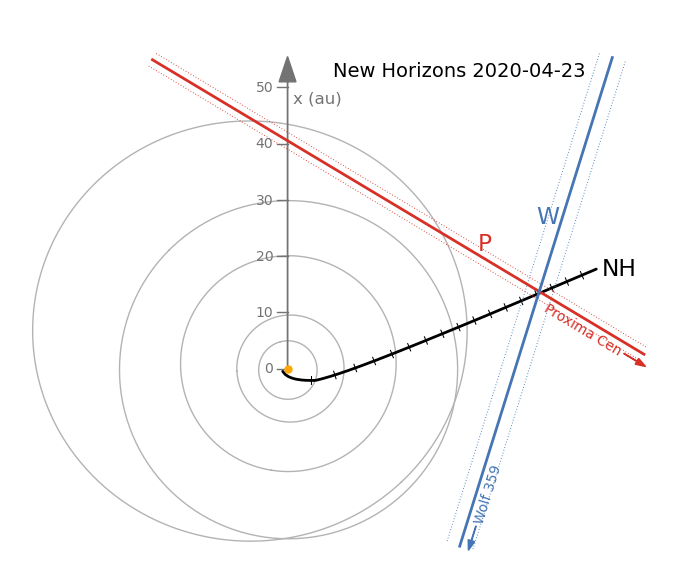

In [87]:
# Figure 3 of paper (called fig1 in this notebook)
# Note that you can call fig1() with increasing values of first argument to
# generate frames of a progressive reveal viewgraph for a presentation.abs
# (See below.)

# nhfig1 caption:
#
# Orbits of the outer planets and New Horizons (NH) viewed from the
# ecliptic north pole.  The dotted line is zero right ascension.  The
# P and W rays show the directions to Proxima Cen and Wolf 359,
# respectively, as measured in NH images on 2020-04-23.  Each ray passes
# through the exact 3D position of its star taken from the Gaia archive,
# so the spacecraft must have been at their intersection point on that
# date.  Proxima Cen is about 45 degrees south of the ecliptic, so the
# P ray is pointing into the page at that angle.  Wolf 359 is nearly in
# the ecliptic plane, and the spacecraft is within 2 degrees.
def fig1(prog=4, save=False, name="nhfig1.png", dpi=300):
    fig_1 = figure(1)
    clf()
    fig_1.set_figwidth(9.77)
    fig_1.set_figheight(7.45)
    fig_1.set_dpi(100.)
    axes(aspect="equal").set_axis_off()
    # axis() -> (-50.768, 69.11, -36.685, 60.451)
    plot(-50.768, 60.451, ".w", ms=0.01)  # force savefig to not crop so all
    plot(69.110, -36.685, ".w", ms=0.01)  # prog values give same png size
    plot(*vernal_up(jup_xyz), c="0.7", lw=1)
    plot(*vernal_up(sat_xyz), c="0.7", lw=1)
    plot(*vernal_up(ura_xyz), c="0.7", lw=1)
    plot(*vernal_up(nep_xyz), c="0.7", lw=1)
    plot(*vernal_up(plu_xyz), c="0.7", lw=1)
    arrow(0, 0, 0, 51, color="0.45", head_width=3, head_length=4.5,
          zorder=2)
    for y in [0, 10, 20, 30, 40, 50]:
        plot([-1.8, 0], [y, y], c="0.45", lw=1)
        text(-2.5, y, str(y), va="center", ha="right", c="0.45", size=10)
    text(1, 48, "x (au)", va="center", ha="left", c="0.45", size=12)
    if prog > 2:
        plot(*nh_ticks, c="k", lw=0.75)
        plot(*nh_xy, c="k", solid_capstyle="round")
        px, py = vernal_up(nh_xyz[:, -1])
        text(px+1, py, "NH", size="large", va="center", ha="left", c="k")
    plot(0, 0, "o", ms=5, c="orange")
    if prog > 3:
        # Note that prox_d and wolf_d do not have vernal_up applied,
        # so they are perpendicular to seg_prox and seg_wolf
        perp = prox_d[:2]
        perp /= sqrt(sum(perp**2))
        xp, yp = perp * rprox * (pi / 180. / 3600.)  # 1 arcsec displacement
        x, y = seg_prox
        plot(x+xp, y+yp, c="#d73027", lw=0.75, dashes=[0.75, 2])
        plot(x-xp, y-yp, c="#d73027", lw=0.75, dashes=[0.75, 2])
        perp = wolf_d[:2]
        perp /= sqrt(sum(perp**2))
        xp, yp = perp * rwolf * (pi / 180. / 3600.)  # 1 arcsec displacement
        x, y = seg_wolf
        plot(x+xp, y+yp, c="#4575b4", lw=0.75, dashes=[0.75, 2])
        plot(x-xp, y-yp, c="#4575b4", lw=0.75, dashes=[0.75, 2])
    if prog > 0:
        plot(*seg_prox, c="#d73027")
        text(35, 22.2, "P", size="large", va="center", ha="center",
             c="#d73027")
        ang = arctan2(*(prox_d[:2]*[1, -1])) * 180./pi
        text(45.1, 2.5, "Proxima Cen", size=10, c="#d73027", rotation=ang)
        c, s = cos(ang * pi/180.), sin(ang * pi/180.)
        arrow(59.8, 2.7, 2.7*c, 2.7*s, width=0.1, head_width=1.2,
              color="#d73027")
    if prog > 1:
        plot(*seg_wolf, c="#4575b4")
        text(46.2, 27, "W", size="large", va="center", ha="center",
             c="#4575b4")
        ang = arctan2(*(wolf_d[:2]*[-1, 1])) * 180./pi
        text(32.9, -27.3, "Wolf 359", size=10, c="#4575b4", rotation=ang)
        c, s = -cos(ang * pi/180.), -sin(ang * pi/180.)
        arrow(33.5, -28, 2.7*c, 2.7*s, width=0.1, head_width=1.2,
              color="#4575b4")
    if prog > 1:
        text(8, 52, "New Horizons 2020-04-23", size=14, c="k")
    axis((-50.768, 69.110, -36.685, None))
    if save:
        if prog < 4:
            name = name.split(".")
            name = ".".join([name[0] + "-{}".format(prog), name[1]])
        savefig(name, dpi=dpi, facecolor="w")


# Lines are skew by about 1/3 AU.
prox_0, wolf_0, pw_skew = closest_pts(prox_p, prox_d, wolf_p, wolf_d)
# distances to proxima and wolf (from SS barycenter)
rprox = sqrt(sum(prox_p**2))
rwolf = sqrt(sum(wolf_p**2))

rot_prox, rot_wolf = uspace_rot(prox_d), uspace_rot(wolf_d)
arrow_prox = arrow_along(prox_q, prox_d, -92, 47)
arrow_wolf = arrow_along(wolf_q, wolf_d, -70, 18)
seg_prox = pts_on_line(prox_q, prox_d, -92, 51.5)
seg_wolf = pts_on_line(wolf_q, wolf_d, -70, 21)
los_dot = array([0., 0.])
prox_line = matmul(rot_prox, (wolf_q + array([[-70.], [21.]])*wolf_d
                              - prox_q)[..., None])[..., 0].T
wolf_line = matmul(rot_wolf, (prox_q + array([[-92.], [51.5]])*prox_d
                              - wolf_q)[..., None])[..., 0].T
prox_nhpos = matmul(rot_prox, nh_xyz - prox_q[:, None])
wolf_nhpos = matmul(rot_wolf, nh_xyz - wolf_q[:, None])

nh_xy = vernal_up(nh_xyz)
nh_ticks = get_ticks(*nh_xy, 1.4)
# 2454102.0 is 2007-01-01 12:00+00:00
tickt = 2454102.0 + 365.25 * arange(17)
ticki = interp(tickt, jpl_nh_jd, arange(jpl_nh_jd.size))
tickf = ticki % 1.0
ticki = (ticki // 1.0).astype(int)
nh_ticks = (1. - tickf)*nh_ticks[..., ticki] + tickf*nh_ticks[..., ticki+1]

# fig1(0)
# fig1(1)
# fig1(2)
# fig1(3)
# fig1(4)
# Use "Save As" button in plot to save the plot as png file.
fig1()

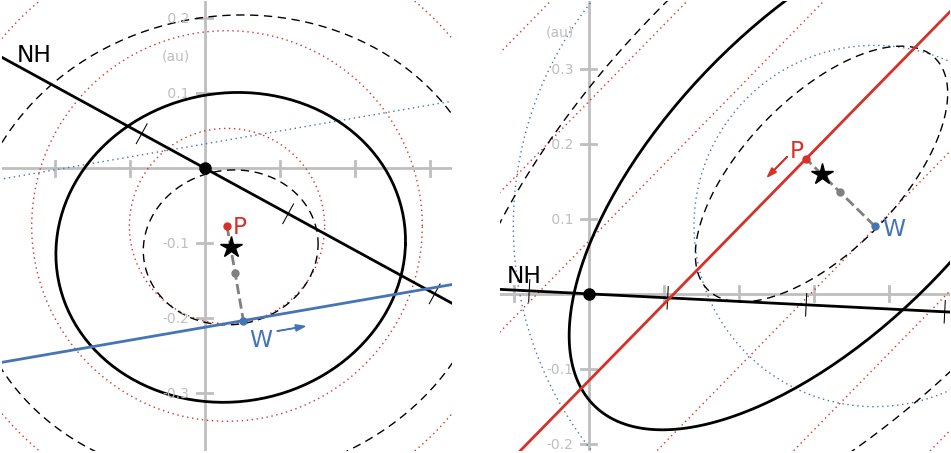

In [88]:
# Figure 4 of paper (called fig2 in this notebook)

# Note that the two ticks on either side of April 23 are April 6 and May 6.
# Distance from x6 to 0.5*(nh_prox + nh_wolf) is 0.35 au.
#   0.082 arcsec from Proxima line and 0.144 arcsec from Wolf line
#   (0.020 pixels from Proxima line and 0.035 pixels from Wolf line)
# Assuming sigma_d = 1 microrad for each individual image, or 0.408 microrad
#   for 6 aggregated images, the chi2 for the final fit is 26.4 for the
#   12 line fit (21 degrees of freedom, 13.2-29.6 is 0.9-0.1),
#   or 0.32 for the 2 line fit (1 degree of freedom, 0.016-2.71 is 0.9-0.1).
#   The fits are behaving exactly as expected.
# For 6 aggregated images, actual  NH position 0.5*(nh_prox + nh_wolf)
#   has chi2 = 4.2 for the 2 line fit (between 0.05 and 0.025 in chi2 distrib)
#   or chi2 = 30.2 for the 12 line fit (between 0.1 and 0.05, near 0.1)
#
# With sigma_a = 0.44 arcsec per image,
# nhmx6 = 0.5*(nh_prox+nh_wolf), x6inv = inv(x6cov)
# actual position is nhmx6.dot(x6inv.dot(nhmx6))/sigma_a**2 = 0.9231 sigma
def fig2(save=False, name="nhfig2.png", dpi=300,
         sigma_a=0.44):
    if not fignum_exists(2):
        fig_2 = figure(2, layout=None)
    else:
        fig_2 = figure(2)
    fig_2.set_figwidth(10)
    fig_2.set_figheight(5)
    fig_2.set_dpi(100.)
    fig_2.clear()
    sigma_a = sigma_a * pi/180./3600.
    gs = fig_2.add_gridspec(nrows=1, ncols=2, left=0.025, right=0.975,
                            top=0.95, bottom=0.05, hspace=0.05, wspace=0.1)
    ax0, ax1 = fig_2.add_subplot(gs[0, 0]), fig_2.add_subplot(gs[0, 1])
    for ax in ax0, ax1:
        ax.clear()
        ax.set_aspect("equal")
        ax.set_axis_off()
    # point to zoom around in ax0: (0, 0), in ax1: (-0.2, 0)
    ax0.axis([-0.30, 0.30, -0.30, 0.30])
    ax1.axis([-0.50, 0.10, -0.30, 0.30])
    for r, n, rot, q, d, _0, line, c1, c2, ax in [
            [rprox, 8, rot_prox, prox_q, prox_d, wolf_0, prox_line,
             "#d73027", "#4575b4", ax0],
            [rwolf, 5, rot_wolf, wolf_q, wolf_d, prox_0, wolf_line,
             "#4575b4", "#d73027", ax1]]:
        is_ax0 = r < 300000.0
        # axes
        xy = matmul(rot, nh_xyz[:, 169:183]-q[:, None])
        ticks = get_ticks(*xy, 0.03)
        xytk = (asfarray(ticks)[:, :, 7] - asfarray(xy)[:, None, 7]) * 1.6
        x0, y0 = matmul(rot, 0.5*(nh_prox + nh_wolf) - q)
        # ax.arrow(x0, y0, 0,0.54, width=0.002, head_width=0.040, color="0.75")
        ax.plot([x0, x0], [y0-0.5, y0+0.5], c="0.75", lw=2)
        for tick in arange(-3, 3):
            tick = 0.1 * (tick if is_ax0 else tick + 1)
            if tick == 0.0:
                continue
            ax.plot([x0-0.01, x0+0.01], [y0+tick, y0+tick], c="0.75", lw=2)
            ax.text(x0-0.02, y0+tick, "{:4.1f}".format(tick),
                    c="0.75", size=10, va="center", ha="right")
        ax.text(x0-0.02, y0+(0.15 if is_ax0 else 0.35), "(au)",
                c="0.75", size=10, va="center", ha="right")
        # ax.arrow(x0, y0,-0.54,0, width=0.002, head_width=0.040, color="0.75")
        ax.plot([x0-0.5, x0+0.5], [y0, y0], c="0.75", lw=2)
        for tick in 0.1*arange(-4, 5):
            if tick == 0.0:
                continue
            ax.plot([x0+tick, x0+tick], [y0-0.01, y0+0.01], c="0.75", lw=2)
        # arcsec circles and lines
        arcsec = r * pi / 180. / 3600
        for rr in arange(1, n) * 0.1 * arcsec:
            ax.plot(*circle_pts(0., 0., rr), c=c1, lw=1, dashes=[1, 2.6])
        x, y = line
        dx, dy = y[0] - y[1], x[1] - x[0]
        rr = sqrt(dx**2 + dy**2)
        dx, dy = dx/rr, dy/rr
        arcsec = (rprox + rwolf - r) * pi / 180. / 3600
        for rr in arange(n-13, 13-n) * 0.1 * arcsec:
            if rr:
                ax.plot(x+rr*dx, y+rr*dy, c=c2, lw=1, dashes=[1, 2.6])
        # NH trajectory (right to left in both views)
        # Ticks are exactly 30 days apart at 00:00:00 UTC
        # 2020-02-06, 2020-03-07, 2020-04-06, 2020-05-06, 2020-06-05
        nh = array([x0, y0])
        ax.plot(*ticks, c="k", lw=0.75)
        ax.plot(*xy, c="k")
        # ax.plot(*(xytk + nh[:, None]), c="k")
        ax.plot(*nh, "o", ms=8, c="k")
        # gray dashed shortest distance line between P and W
        p0, p1 = los_dot, matmul(rot, _0-q)
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], "--", c="0.5")
        kaplan = 0.5*(p0 + p1)
        ax.plot(*kaplan, marker="o", ms=5, c="0.5")  # dot at midpoint
        weighted = matmul(rot, x6-q)  # wxyz-q
        ax.plot(*weighted, marker="*", ms=16, c="k")
        ax.plot(*ellipsoid(*weighted, rot, x6cov, sigma_a), c="k")
        ax.plot(*ellipsoid(*weighted, rot, x6cov, 0.5*sigma_a), c="k",
                lw=1, dashes=[6, 4])
        ax.plot(*ellipsoid(*weighted, rot, x6cov, 1.5*sigma_a), c="k",
                lw=1, dashes=[6, 4])
        # P and W themselves with dots at closest approach
        ax.plot(*p0, "o", ms=5, c=c1)
        ax.plot(*line, c=c2)
        ax.plot(*p1, "o", ms=5, c=c2)
        # annotations
        p0 = matmul(rot, _0 - q)
        p1 = line[:, 1] - line[:, 0]
        p1 /= sqrt(sum(p1**2)) * 40
        if is_ax0:  # this is proxima subplot
            ax.text(-0.28, 0.22, "NH", size="large", c="k")
            # ax.text(0.020, -0.022, "P", size="large", c=c1)
            ax.text(0.008, -0.01, "P", size="large", c=c1)
            ax.text(0.03, -0.16, "W", size="large", c=c2)
            p0 += [0.045, -0.014]
        else:  # this is wolf subplot
            ax.text(-0.49, -0.075, "NH", size="large", c="k")
            ax.text(0.01, -0.012, "W", size="large", c=c1)
            ax.text(-0.113, 0.092, "P", size="large", c=c2)
            p0 += [-0.025, 0.003]
        ax.arrow(*p0, *p1, width=0.0007, head_width=0.0084, color=c2)
    if save:
        savefig(name, dpi=dpi, facecolor="w")


fig2()  # Use "Save As" button in plot to save as png file

### Earth - New Horizons Parallax Comparisons

Analyzed by Marc Buie using Gaia DR3 reference data 02/03/2025
- RA 217.382603533, DEC -62.675294080   (Proxima Cen from LCO)
- RA 164.098440472, DEC 6.999529226   (Wolf 359 from Mt. Lemon)

In [89]:
# Inputs for Earth-spacecraft (ES) parallax comparisons
# See https://doi.org/10.1051/0004-6361/202243483 for details of coordinates.

# Earth observations are ES directions (RA, DEC) in ICRF (02/03/2025)
proxima_e = array([217.382603533, -62.675294080])  # LCO (Marc Buie Gaia DR3)
wolf_e = array([164.098440472, 6.999529226])  # Mt. Lemon (Marc Buie Gaia DR3)
# Other image analyses:
# Proxima Cen:
# [217.38266162087470, -62.675392130007481]  LCO (Marc Buie existing WCS)
# [217.382353364814, -62.674998383579]  CO (Simon Porter Gaia DR3 Cal)
# Wolf 359:
# [164.09866004421113, 6.9996112165345679]  Mt. Lemon (Marc Buie existing WCS)
# [164.098571605986, 6.999476130255]  Mt. Lemon (Simon Porter Gaia DR3 Cal)
p_de = to_xyz(proxima_e)
w_de = to_xyz(wolf_e)

# NH position relative to Earth
nhe_p = nh_at_prox - exyz_p
nhe_w = nh_at_wolf - exyz_w

# Star positions relative to NH and Earth
p_xyz_nh = proxima.p - nh_at_prox
p_xyz_e = proxima.p - exyz_p
w_xyz_nh = wolf.p - nh_at_wolf
w_xyz_e = wolf.p - exyz_w

# Star directions relative to NH and Earth according to Gaia+JPL
p_dnh0 = p_xyz_nh / sqrt(sum(p_xyz_nh**2))
p_de0 = p_xyz_e / sqrt(sum(p_xyz_e**2))
w_dnh0 = w_xyz_nh / sqrt(sum(w_xyz_nh**2))
w_de0 = w_xyz_e / sqrt(sum(w_xyz_e**2))

# NH range and direction relative to Earth
rnhe_p = sqrt(sum(nhe_p**2))
dnhe_p = nhe_p / rnhe_p
rnhe_w = sqrt(sum(nhe_w**2))
dnhe_w = nhe_w / rnhe_w

In [90]:
# Compute Table 2
print("{:16s} {:^27s}  {:^27s}".format("", "Proxima Cen", "Wolf 359"))
fmt = "{:16s} {:^13s} {:^13s}  {:^13s} {:^13s}"
print(fmt.format("", "RA", "Dec", "RA", "Dec"))
fmt = "{:16s} {:13.8f} {:13.8f}  {:13.8f} {:13.8f}"
print(fmt.format("Gaia J2016.0", *proxima.vec0[:2], *wolf.vec0[:2]))
radp, radw = to_ra_dec(proxima.p), to_ra_dec(wolf.p)
print(fmt.format("Gaia NH epoch", *radp[:2], *radw[:2]))
print(fmt.format("NH observed", *p_radec, *w_radec))
radp_nh, radw_nh = to_ra_dec(p_dnh0), to_ra_dec(w_dnh0)
print(fmt.format("NH (Gaia+JPL)", *radp_nh, *radw_nh))
dp = (array(p_radec) - array(radp_nh)) * 3600.0
dp[0] *= cos(radp_nh[1] * pi/180.)
dw = (array(w_radec) - array(radw_nh)) * 3600.0
dw[0] *= cos(radw_nh[1] * pi/180.)
print(fmt.format("  diff (arcsec)", *dp, *dw))
print(fmt.format("Earth observed", *proxima_e, *wolf_e))
radp_e, radw_e = to_ra_dec(p_de0), to_ra_dec(w_de0)
print(fmt.format("Earth (Gaia+JPL)", *radp_e[:2], *radw_e[:2]))
dp = (array(proxima_e) - array(radp_e)) * 3600.0
dp[0] *= cos(radp_nh[1] * pi/180.)
dw = (array(wolf_e) - array(radw_e)) * 3600.0
dw[0] *= cos(radw_nh[1] * pi/180.)
print(fmt.format("  diff (arcsec)", *dp, *dw))


# Note that the difference between the directions of a star as observed
# from NH (p_dbar, w_dbar) and Earth (p_de, w_de) is the directly observed
# parallax.  Each of these directions has a "true" value (p_dnh0, w_dnh0 and
# p_de0, w_de0) computed from Gaia DR3 for the stars and JPL Horizons for NH
# and Earth.
def on_sky(r):
    """return rotation matrix which maps vectors near r to (dra, ddec, dr)"""
    r = r / sqrt(sum(r**2))
    ra = r[[1, 0, 2]]*array([-1., 1., 0.])
    ra /= sqrt(sum(ra**2) + 1.e-99)
    dec = cross(ra, r)
    return array([ra, dec, r])


sky_near_p = on_sky(p_de)
sky_near_w = on_sky(w_de)
p_obs = sky_near_p.dot(p_dbar) * pc  # pc converts radians to arcsec
w_obs = sky_near_w.dot(w_dbar) * pc
p_plx = sqrt(sum(p_obs[:2]**2))
w_plx = sqrt(sum(w_obs[:2]**2))
sky_near_p0 = on_sky(p_de0)
sky_near_w0 = on_sky(w_de0)
p_tru = sky_near_p0.dot(p_dnh0) * pc
w_tru = sky_near_w0.dot(w_dnh0) * pc
p_plx0 = sqrt(sum(p_tru[:2]**2))
w_plx0 = sqrt(sum(w_tru[:2]**2))

print("\nDifference between NH and Earth directions to star (arcsec)")
print("{:6s}  {:^20s}  {:^20s}".format("", "Proxima Cen", "Wolf 359"))
fmt = "{:6s} {:^6s} {:^6s} {:^6s}   {:^6s} {:^6s} {:^6s}"
print(fmt.format("", "dRA", "dDec", "tot", "dRA", "dDec", "tot"))
fmt = "{:6s} {:6.2f} {:6.2f} {:6.2f}   {:6.2f} {:6.2f} {:6.2f}"
print(fmt.format("obs", *p_obs[:2], p_plx, *w_obs[:2], w_plx))
print(fmt.format("calc", *p_tru[:2], p_plx0, *w_tru[:2], w_plx0))
print(fmt.format("O-C", *(p_obs-p_tru)[:2], p_plx-p_plx0,
                 *(w_obs-w_tru)[:2], w_plx-w_plx0))

# Distances of NH and Earth from SSB
rnhbar = sqrt(sum(newh_x**2))
rebar = 0.5*sqrt(sum((exyz_p+exyz_w)**2))
print("\nDistance from SSB {:8.5f} (NH) {:8.5f} (Earth)".format(rnhbar, rebar))


                         Proxima Cen                   Wolf 359          
                      RA            Dec            RA            Dec     
Gaia J2016.0      217.39232147  -62.67607512   164.10319031    7.00272694
Gaia NH epoch     217.38246430  -62.67515412   164.09852751    6.99949593
NH observed       217.36314702  -62.67632413   164.09430056    7.00100822
NH (Gaia+JPL)     217.36311984  -62.67633603   164.09426343    7.00103475
  diff (arcsec)     0.04490456    0.04281080     0.13267304   -0.09553067
Earth observed    217.38260353  -62.67529408   164.09844047    6.99952923
Earth (Gaia+JPL)  217.38252116  -62.67531791   164.09844471    6.99953024
  diff (arcsec)     0.13612269    0.08580478    -0.01515816   -0.00365283

Difference between NH and Earth directions to star (arcsec)
            Proxima Cen             Wolf 359      
        dRA    dDec   tot      dRA    dDec   tot  
obs    -32.15   3.71  32.36   -14.79  -5.32  15.72
calc   -32.06   3.67  32.27   -14.94  -5.42  1

### Stellar Aberration

In [91]:
# Estimates of stellar aberration

# Lorentz transformation of (omega, k) 4-vector
#   kp = gamma*(k - beta*kz)  where k = omega/c
#   kzp = gamma*(kz - beta*k)  where k**2 = kx**2 + kz**2
#   kxp = kx  is transverse component as a magnitude > 0
# Note that the k vector points in the direction opposite to the star, so
#   cos(theta)=-kz/k, sin(theta)=kx/k, cos(thetap)=-kzp/kp, sin(thetap)=kxp/kp
# Thus
#   kp/k = gamma*(1 + beta*cos(theta))  is Doppler shift
#   tan(thetap) = sin(theta)/(cos(theta) + beta) / gamma  is aberration
# For small beta, this is
#   tan(thetap) = tan(theta) - beta*tan(theta)*sec(theta)  or
#   thetap = theta - beta*sin(theta)
#   phip = phi
# where the complete sky mapping is (theta, phi) --> (thetap, phip)

# spacecraft
betap = jpl_sp / 299792.458
jpl_vpdir = jpl_vp / jpl_sp
betaw = jpl_sw / 299792.458
jpl_vwdir = jpl_vw / jpl_sw
p_cos, w_cos = p_dbar.dot(jpl_vpdir), w_dbar.dot(jpl_vwdir)
p_sin, w_sin = sqrt(1. - p_cos**2), sqrt(1. - w_cos**2)
p_angle = arccos(p_cos)
p_aber = (arctan2(p_sin, p_cos+betap) - p_angle) * pc
w_angle = arccos(w_cos)
w_aber = (arctan2(w_sin, w_cos+betaw) - w_angle) * pc

# earth
betaep = jpl_sep / 299792.458
jpl_vepdir = jpl_vep / jpl_sep
betaew = jpl_sew / 299792.458
jpl_vewdir = jpl_vew / jpl_sew
p_cose, w_cose = p_dbar.dot(jpl_vepdir), w_dbar.dot(jpl_vewdir)
p_sine, w_sine = sqrt(1. - p_cose**2), sqrt(1. - w_cose**2)
p_eangle = arccos(p_cose)
p_eaber = (arctan2(p_sine, p_cose+betaep) - p_eangle) * pc
w_eangle = arccos(w_cose)
w_eaber = (arctan2(w_sine, w_cose+betaew) - w_eangle) * pc

# Aberration also causes a small scale change in the sky, slightly
# shrinking the star field looking along the velocity, and slightly
# magnifying it looking opposite the velocity (with just the shift looking
# transverse to the velocity).
# Conside a small square patch of angle da in both the theta and phi
# direction.  Note that da = dphi*sin(theta).  The mapping takes
#   theta+da --> thetap+da - beta*cos(theta)*da
# so that the patch length da changes by a factor of 1 - beta*cos(theta).
# Similarly, the width of the patch goes from
#   da --> dphi*sin(thetap) = da*sin(thetap)/sin(theta)
#   and sin(thetap) = sin(theta) + cos(theta)*(thetap-theta)
#                   = sin(theta) - beta*sin(theta)*cos(theta), so
#   da --> da*(1 - beta*cos(theta))
# So the (theta, phi) --> (thetp, phip) mapping causes a uniform scale factor
#   scale = 1 - beta*cos(theta)
#   fractional change = -beta*cos(theta)
nh_afrac_p, nh_afrac_w = -betap*p_cos, -betaw*w_cos
e_afrac_p, e_afrac_w = -betaep*p_cose, -betaew*w_cose

lorri_hw = 0.1450666 * 3600.  # LORRI field half-width in arcsec

print("Stellar aberration for NH:")
print("  Proxima Cen   speed = {:6.3f} km/s, theta = {:7.2f} deg".
      format(jpl_sp, p_angle*180./pi))
print("                aberration = {:6.3f} arcsec".format(-p_aber))
print("                stretch = {:9.6f}, lorri E-C = {:6.3f} arcsec".
      format(nh_afrac_p, nh_afrac_p*lorri_hw))
print("  Wolf 359      speed = {:6.3f} km/s, theta = {:7.2f} deg".
      format(jpl_sw, w_angle*180./pi))
print("                aberration = {:6.3f} arcsec".format(-w_aber))
print("                stretch = {:9.6f}, lorri E-C = {:6.3f} arcsec".
      format(nh_afrac_w, nh_afrac_w*lorri_hw))
print("\nStellar aberration for Earth:")
print("  Proxima Cen   speed = {:6.3f} km/s, theta = {:7.2f} deg".
      format(jpl_sep, p_eangle*180./pi))
print("                aberration = {:6.3f} arcsec".format(-p_eaber))
print("                stretch = {:9.6f}".format(e_afrac_p))
print("  Wolf 359      speed = {:6.3f} km/s, theta = {:7.2f} deg".
      format(jpl_sew, w_eangle*180./pi))
print("                aberration = {:6.3f} arcsec".format(-w_eaber))
print("                stretch = {:9.6f}".format(e_afrac_w))


Stellar aberration for NH:
  Proxima Cen   speed = 13.967 km/s, theta =   66.85 deg
                aberration =  8.836 arcsec
                stretch = -0.000018, lorri E-C = -0.010 arcsec
  Wolf 359      speed = 13.967 km/s, theta =  130.22 deg
                aberration =  7.338 arcsec
                stretch =  0.000030, lorri E-C =  0.016 arcsec

Stellar aberration for Earth:
  Proxima Cen   speed = 29.630 km/s, theta =   71.13 deg
                aberration = 19.290 arcsec
                stretch = -0.000032
  Wolf 359      speed = 29.628 km/s, theta =  139.72 deg
                aberration = 13.179 arcsec
                stretch =  0.000075
